<a href="https://colab.research.google.com/github/orangegreen212/Sentiment-Analysis-LTSM-and-BERT-Model/blob/main/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project Overview: Sentiment Analysis of Movie Reviews

This script implements a complete pipeline to perform sentiment analysis on a dataset of movie reviews. The project is broken down into the following key stages:

  1. Data Loading and Preparation: The dataset is loaded, and a target variable (sentiment) is created based on the original movie ratings.

  2. Text Cleaning: A function is defined and applied to clean the raw text data by removing punctuation, and converting all text to lowercase.

  3. Tokenization and Stop Word Removal: The cleaned text is broken down into individual words (tokens), and common but non-informative words (stop words) are removed.

  4. Lemmatization: Words are reduced to their base or dictionary form (e.g., "running" and "ran" both become "run") to standardize the text.

  5. Vectorization: The processed text is converted into a numerical format that a neural network can understand. This involves creating a vocabulary and replacing each word with its corresponding integer index.

  6. PyTorch Dataset and DataLoader Creation: The numerical data is wrapped into custom PyTorch Dataset and DataLoader classes for efficient batching and feeding into the model.

  7. Model Creation (LSTM): A neural network architecture is built using PyTorch. It features a Long Short-Term Memory (LSTM) layer, which is well-suited for processing sequential data like text.

  8. Model Training: A training loop is implemented to teach the model how to distinguish between positive and negative sentiment based on the prepared data.

  9. Inference and Testing: The trained model's quality is evaluated, and a final function is created to analyze the sentiment of any new, arbitrary text string.

## Setup and Data Preparation

This is the foundational stage where the environment and data are prepared for analysis.

    Imports: It imports all necessary libraries: pandas for data manipulation, nltk for text processing, torch for building the neural network, sklearn for splitting data, and collections for counting words.

    NLTK Downloads: It downloads essential NLTK resources (punkt for tokenization, stopwords for a list of common words, wordnet for lemmatization).

    Data Loading: It loads the dataset from a CSV file located at /content/drive/MyDrive/Data for GC/movie_reviews_table.csv into a pandas DataFrame.

    Initial Cleaning: It removes any rows that have a missing review content (review_content).

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from collections import Counter

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [2]:
data = pd.read_csv("/content/drive/MyDrive/Data for GC/movie_reviews_table.csv")
data

,movie_id,movie_title,review_author,review_content,review_url,review_created_at,author_rating
0,1417059,Mountainhead,MovieGuys,"""Moutainhead""aspires to be more, than it reaso...",https://www.themoviedb.org/review/683fc1fdceb7...,2025-06-04T03:48:13.361Z,6.0
1,1001414,Fear Street: Prom Queen,Manuel São Bento,FULL SPOILER-FREE REVIEW @ https://movieswetex...,https://www.themoviedb.org/review/6830975507c6...,2025-05-23T15:42:13.781Z,5.0
2,1001414,Fear Street: Prom Queen,r96sk,<em>'Fear Street: Prom Queen'</em> is all too ...,https://www.themoviedb.org/review/683e459f8968...,2025-06-03T00:45:19.975Z,5.0
3,1098006,Fountain of Youth,Manuel São Bento,FULL SPOILER-FREE REVIEW @ https://fandomwire....,https://www.themoviedb.org/review/682f6478c2aa...,2025-05-22T17:52:56.672Z,7.0
4,1098006,Fountain of Youth,Brent Western,I came into this movie hearing that it wasn’t ...,https://www.themoviedb.org/review/6835fa592f02...,2025-05-27T17:46:01.181Z,8.0
...,...,...,...,...,...,...,...
2892,49538,X-Men: First Class,Travis Bell,I didn't love this movie. There were aspects a...,https://www.themoviedb.org/review/52aa15e919c2...,2013-12-12T20:00:41.186Z,7.5
2893,49538,X-Men: First Class,DoryDarko,"On IMDb, X-Men: First Class has garnered the h...",https://www.themoviedb.org/review/58ac565ac3a3...,2017-02-21T15:01:46.081Z,9.0
2894,49538,X-Men: First Class,r96sk,My favourite so far.\r\n\r\n<em>'X-Men: First ...,https://www.themoviedb.org/review/60a8736f66e4...,2021-05-22T02:58:55.623Z,8.0
2895,49538,X-Men: First Class,CinemaSerf,"If it's not sacrilegious for a Brit, I found t...",https://www.themoviedb.org/review/638ba3154202...,2022-12-03T19:27:17.507Z,7.0


In [3]:
data.dropna(subset=['review_content'], inplace=True)

## The "From-Scratch" LSTM Model Approach


Text Preprocessing (clean_and_tokenize function):

    A custom list of stop words (common but uninformative words like 'film', 'movie', 'review') is created and added to the standard English list.

    A function is defined to clean each review:

        It removes all non-alphabetic characters and converts the text to lowercase.

        It tokenizes the text (splits it into a list of words).

        It lemmatizes each word (reduces it to its base form, e.g., "was" -> "be", "reviews" -> "review") and removes stop words.

    This function is applied to every review, creating a new column cleaned_tokens.

In [4]:
stop_words = set(stopwords.words('english'))

custom_stop_words = [
    'full', 'spoiler', 'free', 'review', 'read', 'more', 'see',
    'fandomwire', 'movieswetex', 'https', 'www', 'com', 'org', 'street', 'prom', 'queen', 'imdb',
    'movie', 'film', 'cinema'
]
stop_words.update(custom_stop_words)
lemmatizer = WordNetLemmatizer()

def clean_and_tokenize(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text.lower())
    tokens = word_tokenize(text)
    cleaned_tokens = [
        lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 1
    ]
    return cleaned_tokens

data['cleaned_tokens'] = data['review_content'].apply(clean_and_tokenize)

print("\nAfter cleaning:")
print(data[['review_content', 'cleaned_tokens']].head())


After cleaning:
                                      review_content  \
0  "Moutainhead"aspires to be more, than it reaso...   
1  FULL SPOILER-FREE REVIEW @ https://movieswetex...   
2  <em>'Fear Street: Prom Queen'</em> is all too ...   
3  FULL SPOILER-FREE REVIEW @ https://fandomwire....   
4  I came into this movie hearing that it wasn’t ...   

                                      cleaned_tokens  
0  [moutainhead, aspires, reasonably, achieves, o...  
1  [fear, dispensable, entry, saga, deserves, att...  
2  [fear, forgettable, eye, anyway, felt, derivat...  
3  [fountain, youth, prime, example, craft, quali...  
4  [came, hearing, cracked, bit, lifeless, paint,...  


In [5]:
data[['review_content', 'cleaned_tokens']]

,review_content,cleaned_tokens
0,"""Moutainhead""aspires to be more, than it reaso...","[moutainhead, aspires, reasonably, achieves, o..."
1,FULL SPOILER-FREE REVIEW @ https://movieswetex...,"[fear, dispensable, entry, saga, deserves, att..."
2,<em>'Fear Street: Prom Queen'</em> is all too ...,"[fear, forgettable, eye, anyway, felt, derivat..."
3,FULL SPOILER-FREE REVIEW @ https://fandomwire....,"[fountain, youth, prime, example, craft, quali..."
4,I came into this movie hearing that it wasn’t ...,"[came, hearing, cracked, bit, lifeless, paint,..."
...,...,...
2892,I didn't love this movie. There were aspects a...,"[love, aspect, perspective, origin, story, int..."
2893,"On IMDb, X-Men: First Class has garnered the h...","[men, first, class, garnered, highest, rating,..."
2894,My favourite so far.\r\n\r\n<em>'X-Men: First ...,"[favourite, far, men, first, class, great, fun..."
2895,"If it's not sacrilegious for a Brit, I found t...","[sacrilegious, brit, found, outing, men, far, ..."


### Vectorization (Text to Numbers):

    It creates a vocabulary by counting all unique tokens in the dataset.

    It builds a dictionary (word_to_idx) that maps the 10,000 most common words to a unique integer index. Special tokens for padding (<PAD>) and unknown words (<UNK>) are added.

    It converts each list of tokens into a list of corresponding integer indices, creating a new column indexed_review.

In [6]:

all_tokens = [token for tokens_list in data['cleaned_tokens'] for token in tokens_list]

word_counts = Counter(all_tokens)

vocab_size = 10000
sorted_words = word_counts.most_common(vocab_size - 2)


word_to_idx = {word: i+2 for i, (word, count) in enumerate(sorted_words)}
word_to_idx['<PAD>'] = 0
word_to_idx['<UNK>'] = 1


def numericalize(tokens, word_to_idx):
    return [word_to_idx.get(token, word_to_idx['<UNK>']) for token in tokens]

data['indexed_review'] = data['cleaned_tokens'].apply(lambda x: numericalize(x, word_to_idx))

print(data[['cleaned_tokens', 'indexed_review']].head())

                                      cleaned_tokens  \
0  [moutainhead, aspires, reasonably, achieves, o...   
1  [fear, dispensable, entry, saga, deserves, att...   
2  [fear, forgettable, eye, anyway, felt, derivat...   
3  [fountain, youth, prime, example, craft, quali...   
4  [came, hearing, cracked, bit, lifeless, paint,...   

                                      indexed_review  
0  [1, 7345, 2869, 3451, 2, 147, 2165, 1156, 1, 1...  
1  [533, 1, 603, 862, 888, 469, 327, 27, 1158, 68...  
2  [533, 1001, 288, 563, 117, 1, 5274, 690, 534, ...  
3  [6452, 1459, 2413, 582, 1676, 230, 2534, 1724,...  
4  [352, 2248, 8557, 38, 5275, 4835, 558, 9, 8558...  


### Label Generation (CRITICAL STEP):
    Crucially, this script does not use real sentiment labels from the data. Instead, for this experimental run, it generates random labels (0 or 1) for every review using np.random.randint.

    This is a key point: A model trained on random data cannot learn anything meaningful about the relationship between text and sentiment. Its accuracy will always be around 50%. This part of the script is for testing the pipeline, not for achieving a useful result.

In [7]:
labeled_df = data[['cleaned_tokens', 'indexed_review']].copy()

In [8]:
random_labels = np.random.randint(0, 2, size=len(labeled_df))

labeled_df['sentiment'] = random_labels
print(labeled_df.head())

X = labeled_df['indexed_review'].tolist()
y = labeled_df['sentiment'].tolist()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("\nData with random labels were created.")


                                      cleaned_tokens  \
0  [moutainhead, aspires, reasonably, achieves, o...   
1  [fear, dispensable, entry, saga, deserves, att...   
2  [fear, forgettable, eye, anyway, felt, derivat...   
3  [fountain, youth, prime, example, craft, quali...   
4  [came, hearing, cracked, bit, lifeless, paint,...   

                                      indexed_review  sentiment  
0  [1, 7345, 2869, 3451, 2, 147, 2165, 1156, 1, 1...          0  
1  [533, 1, 603, 862, 888, 469, 327, 27, 1158, 68...          0  
2  [533, 1001, 288, 563, 117, 1, 5274, 690, 534, ...          0  
3  [6452, 1459, 2413, 582, 1676, 230, 2534, 1724,...          0  
4  [352, 2248, 8557, 38, 5275, 4835, 558, 9, 8558...          0  

Data with random labels were created.


In [9]:
labeled_df

,cleaned_tokens,indexed_review,sentiment
0,"[moutainhead, aspires, reasonably, achieves, o...","[1, 7345, 2869, 3451, 2, 147, 2165, 1156, 1, 1...",0
1,"[fear, dispensable, entry, saga, deserves, att...","[533, 1, 603, 862, 888, 469, 327, 27, 1158, 68...",0
2,"[fear, forgettable, eye, anyway, felt, derivat...","[533, 1001, 288, 563, 117, 1, 5274, 690, 534, ...",0
3,"[fountain, youth, prime, example, craft, quali...","[6452, 1459, 2413, 582, 1676, 230, 2534, 1724,...",0
4,"[came, hearing, cracked, bit, lifeless, paint,...","[352, 2248, 8557, 38, 5275, 4835, 558, 9, 8558...",0
...,...,...,...
2892,"[love, aspect, perspective, origin, story, int...","[51, 334, 999, 728, 5, 197, 71, 452, 155, 117,...",1
2893,"[men, first, class, garnered, highest, rating,...","[134, 14, 546, 5629, 2500, 132, 26, 134, 89, 9...",1
2894,"[favourite, far, men, first, class, great, fun...","[479, 91, 134, 14, 546, 12, 59, 117, 1427, 271...",0
2895,"[sacrilegious, brit, found, outing, men, far, ...","[1, 7571, 190, 1514, 134, 91, 54, 85, 759, 28,...",0


In [10]:
print(f"Current len of DataFrame 'data': {len(data)} strings.")

Current len of DataFrame 'data': 2897 strings.


### PyTorch Data Preparation:
    The MovieReviewDataset class is defined to format the data correctly for PyTorch. It pads or truncates each review to a fixed length (seq_len=250).

    The data is split into a training set (80%) and a validation set (20%).

    DataLoaders are created to feed the data to the model in batches (groups of 64 reviews at a time).

In [11]:
#   1. DEFINE THE MODEL ARCHITECTURE

class SentimentLSTM(nn.Module):
    """
    An LSTM-based neural network for sentiment classification.
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, drop_prob=0.4):
        super().__init__()

        # Embedding Layer: Converts integer indices into dense vectors of a fixed size.
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # LSTM Layer: Processes the sequence of embeddings to capture context.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,
                            bidirectional=bidirectional, dropout=drop_prob, batch_first=True)

        # Dropout Layer: A regularization technique to prevent overfitting.
        self.dropout = nn.Dropout(drop_prob)

        # Fully Connected Layer: Produces the final output score.
        # The input features are doubled if the LSTM is bidirectional.
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)

    def forward(self, x):
        # Pass the input through the embedding layer.
        embedded = self.embedding(x)

        # Pass the embeddings through the LSTM layer.
        lstm_out, (hidden, cell) = self.lstm(embedded)

        # Concatenate the final forward and backward hidden states if bidirectional.
        if self.lstm.bidirectional:
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            # Otherwise, just use the final hidden state of the last layer.
            hidden = hidden[-1,:,:]

        # Apply dropout and pass through the final fully connected layer.
        out = self.dropout(hidden)
        out = self.fc(out)

        return out

print("Step 1: The 'SentimentLSTM' class has been defined.")

#   2. DEFINE HYPERPARAMETERS AND INSTANTIATE THE MODEL

# --- Model Hyperparameters ---
# The size of our vocabulary (number of unique words).
vocab_size = len(word_to_idx)
# The size of the dense word vectors.
embedding_dim = 100
# The number of features in the LSTM's hidden state.
hidden_dim = 64
# The size of the output (1 for binary classification).
output_dim = 1
# The number of stacked LSTM layers.
n_layers = 2
# Use a bidirectional LSTM.
bidirectional = True
# The dropout probability.
drop_prob = 0.5

# --- Instantiate the Model ---
model = SentimentLSTM(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    n_layers=n_layers,
    bidirectional=bidirectional,
    drop_prob=drop_prob
)

print("\n--- Model Architecture ---")
print(model)


#   3. SET UP THE LOSS FUNCTION, OPTIMIZER, AND DEVICE

# --- Loss Function ---
# BCEWithLogitsLoss is a good choice for binary classification. It is more
# numerically stable than using a Sigmoid layer followed by BCELoss.
criterion = nn.BCEWithLogitsLoss()

# --- Optimizer ---
# Adam is a standard and highly effective optimization algorithm for updating the model's weights.
optimizer = optim.Adam(model.parameters(), lr=0.001)

# --- Device Selection (GPU or CPU) ---
# Select GPU if available, otherwise fall back to CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model and criterion to the selected device.
model.to(device)
criterion.to(device)

print(f"\nModel moved to device: {device}")

Step 1: The 'SentimentLSTM' class has been defined.

--- Model Architecture ---
SentimentLSTM(
  (embedding): Embedding(10000, 100)
  (lstm): LSTM(100, 64, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Model moved to device: cuda


In [12]:
class MovieReviewDataset(Dataset):
    def __init__(self, reviews, labels, seq_len=250):
        self.reviews, self.labels, self.seq_len = reviews, labels, seq_len
    def __len__(self): return len(self.reviews)
    def __getitem__(self, idx):
        review = self.reviews[idx]
        if len(review) > self.seq_len: review = review[:self.seq_len]
        else: review = review + [word_to_idx['<PAD>']] * (self.seq_len - len(review))
        return torch.tensor(review), torch.tensor(self.labels[idx])

# Creating Dataset и DataLoader
X = labeled_df['indexed_review'].tolist()
y = labeled_df['sentiment'].tolist()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
train_dataset = MovieReviewDataset(X_train, y_train)
val_dataset = MovieReviewDataset(X_val, y_val)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
print("'train_loader' and 'val_loader' were created.")


'train_loader' and 'val_loader' were created.


### Model Architecture and Training:

In [13]:
import torch

# Define a function to calculate accuracy for binary classification
def binary_accuracy(preds, y):
    """
    Calculates accuracy percentage.
    """
    # Convert model outputs (logits) to probabilities (0 to 1) using the sigmoid function,
    # then round to the nearest integer (0 or 1) to get the final prediction.
    rounded_preds = torch.round(torch.sigmoid(preds))

    # Compare rounded predictions to the true labels (y).
    # '.float()' converts the boolean tensor (True/False) to (1.0/0.0).
    correct = (rounded_preds == y).float()

    # Calculate the mean of the correct predictions.
    acc = correct.sum() / len(correct)
    return acc

# Set the number of training epochs
epochs = 10 # 10 epochs is a good starting point. This can be adjusted later.

# Start the main training loop
for epoch in range(epochs):

    #   TRAINING PHASE


    # Set the model to training mode. This enables layers like Dropout.
    model.train()

    # Initialize trackers for loss and accuracy for this epoch
    epoch_loss = 0
    epoch_acc = 0

    # Iterate over the training data in batches
    for reviews, labels in train_loader:

        # Move the data batch to the selected device (GPU or CPU)
        reviews, labels = reviews.to(device), labels.to(device)

        # 1. Clear old gradients from the previous iteration
        optimizer.zero_grad()

        # 2. Forward Pass: Make predictions on the current batch
        # '.squeeze(1)' removes the extra dimension from the model's output
        predictions = model(reviews).squeeze(1)

        # 3. Calculate Loss and Accuracy
        # Compare model predictions with the true labels
        loss = criterion(predictions, labels.float())
        acc = binary_accuracy(predictions, labels)

        # 4. Backward Pass: Calculate gradients
        # This computes how much each model parameter contributed to the error
        loss.backward()

        # 5. Update Weights: Adjust model parameters
        # The optimizer uses the calculated gradients to update the model's weights
        optimizer.step()

        # Accumulate the loss and accuracy for the epoch
        epoch_loss += loss.item()
        epoch_acc += acc.item()


    #   VALIDATION PHASE

    # Set the model to evaluation mode. This disables layers like Dropout.
    model.eval()

    # Initialize trackers for validation loss and accuracy
    val_loss = 0
    val_acc = 0

    # Disable gradient calculations for the validation phase to save memory and computation
    with torch.no_grad():

        # Iterate over the validation data
        for reviews, labels in val_loader:
            reviews, labels = reviews.to(device), labels.to(device)

            # Make predictions (no training happens here)
            predictions = model(reviews).squeeze(1)

            # Calculate loss and accuracy on the validation data
            loss = criterion(predictions, labels.float())
            acc = binary_accuracy(predictions, labels)

            # Accumulate the validation loss and accuracy
            val_loss += loss.item()
            val_acc += acc.item()

    # Print a summary of the epoch's performance
    print(f'Epoch: {epoch+1:02} | '
          f'Train Loss: {epoch_loss/len(train_loader):.3f} | Train Acc: {epoch_acc/len(train_loader)*100:.2f}% | '
          f'Val. Loss: {val_loss/len(val_loader):.3f} |  Val. Acc: {val_acc/len(val_loader)*100:.2f}%')

Epoch: 01 | Train Loss: 0.697 | Train Acc: 47.32% | Val. Loss: 0.695 |  Val. Acc: 47.19%
Epoch: 02 | Train Loss: 0.691 | Train Acc: 52.30% | Val. Loss: 0.696 |  Val. Acc: 42.97%
Epoch: 03 | Train Loss: 0.688 | Train Acc: 55.46% | Val. Loss: 0.696 |  Val. Acc: 46.88%
Epoch: 04 | Train Loss: 0.666 | Train Acc: 60.65% | Val. Loss: 0.711 |  Val. Acc: 50.31%
Epoch: 05 | Train Loss: 0.623 | Train Acc: 65.73% | Val. Loss: 0.775 |  Val. Acc: 43.91%
Epoch: 06 | Train Loss: 0.522 | Train Acc: 75.86% | Val. Loss: 0.901 |  Val. Acc: 49.69%
Epoch: 07 | Train Loss: 0.382 | Train Acc: 83.87% | Val. Loss: 1.090 |  Val. Acc: 50.31%
Epoch: 08 | Train Loss: 0.245 | Train Acc: 91.13% | Val. Loss: 1.326 |  Val. Acc: 51.25%
Epoch: 09 | Train Loss: 0.147 | Train Acc: 94.34% | Val. Loss: 1.746 |  Val. Acc: 49.38%
Epoch: 10 | Train Loss: 0.109 | Train Acc: 96.37% | Val. Loss: 1.681 |  Val. Acc: 51.25%


### Testing the Custom Model:

    The predict_sentiment function is defined to take a raw text string, run it through the entire preprocessing pipeline, and get a prediction from the trained LSTM model.

    This function is used to test a few example sentences.

In [14]:
def predict_sentiment(text, model, word_to_idx, device, seq_len=200):
    """
    Predicts the sentiment of a single text string using the trained LSTM model.

    Args:
        text (str): The raw text to analyze.
        model (nn.Module): The trained PyTorch model.
        word_to_idx (dict): The vocabulary mapping words to their integer indices.
        device (torch.device): The device to run the model on (e.g., 'cuda' or 'cpu').
        seq_len (int): The sequence length the model was trained with.

    Returns:
        (str, float): A tuple containing the predicted sentiment ("Positive" or "Negative")
                      and the corresponding probability for the positive class.
    """

    # Set the model to evaluation mode. This disables layers like Dropout.
    model.eval()

    # 1. Preprocess the text (apply the same steps as for the training data)
    # The 'clean_and_tokenize' and 'numericalize' functions are assumed to be defined elsewhere.
    tokens = clean_and_tokenize(text)
    indexed_tokens = numericalize(tokens, word_to_idx)

    # 2. Pad or truncate the sequence to a fixed length
    # The input to the model must have a consistent length.
    if len(indexed_tokens) > seq_len:
        # Truncate if the text is too long
        padded_tokens = indexed_tokens[:seq_len]
    else:
        # Pad with the <PAD> token's index if the text is too short
        padding_needed = seq_len - len(indexed_tokens)
        padded_tokens = indexed_tokens + [word_to_idx['<PAD>']] * padding_needed

    # 3. Convert to a tensor and send to the correct device
    # The '.unsqueeze(0)' adds a batch dimension (from [seq_len] to [1, seq_len]),
    # as the model expects a batch of inputs.
    input_tensor = torch.LongTensor(padded_tokens).unsqueeze(0).to(device)

    # 4. Make a prediction
    # 'torch.no_grad()' is used for inference to disable gradient calculations,
    # which saves memory and computation.
    with torch.no_grad():
        # The model outputs raw logits (unnormalized scores).
        prediction = model(input_tensor)

    # 5. Convert logits to a probability and determine the final sentiment
    # Apply the sigmoid function to squash the logit into a probability between 0 and 1.
    # '.item()' extracts the single float value from the tensor.
    probability = torch.sigmoid(prediction).item()

    # Use a 0.5 threshold to make the final decision.
    sentiment = "Positive" if probability > 0.5 else "Negative"

    return sentiment, probability

# Model Testing
test_review_pos = "I absolutely loved this movie! The characters were amazing and the plot was fantastic. A must see!"
test_review_neg = "This was a complete waste of my time. The story was boring and the acting was just awful. I do not recommend."
test_review_neutral = "The movie was okay. Some good parts, some bad parts. Nothing special."

sentiment, prob = predict_sentiment(test_review_pos, model, word_to_idx, device)
print(f'Review: "{test_review_pos}"')
print(f'Result: {sentiment} (Confidencey: {prob:.4f})\n')

sentiment, prob = predict_sentiment(test_review_neg, model, word_to_idx, device)
print(f'Review: "{test_review_neg}"')
print(f'Result: {sentiment} (Confidence: {prob:.4f})\n')

sentiment, prob = predict_sentiment(test_review_neutral, model, word_to_idx, device)
print(f'Review: "{test_review_neutral}"')
print(f'Result: {sentiment} (Confidence: {prob:.4f})\n')

Review: "I absolutely loved this movie! The characters were amazing and the plot was fantastic. A must see!"
Result: Negative (Confidencey: 0.3506)

Review: "This was a complete waste of my time. The story was boring and the acting was just awful. I do not recommend."
Result: Positive (Confidence: 0.9870)

Review: "The movie was okay. Some good parts, some bad parts. Nothing special."
Result: Negative (Confidence: 0.2471)



In [15]:
print("Labels distribution in training set:")
print(pd.Series(y_train).value_counts())

Labels distribution in training set:
1    1172
0    1145
Name: count, dtype: int64


Checked 580 examples.


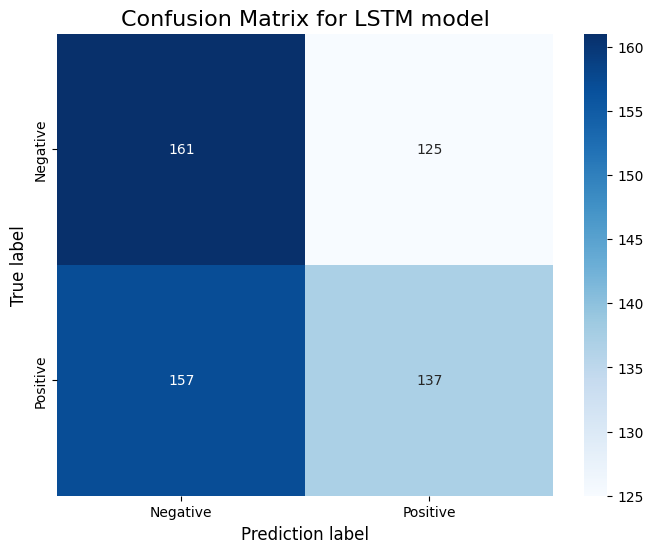


Classification report:

              precision    recall  f1-score   support

    Negative       0.51      0.56      0.53       286
    Positive       0.52      0.47      0.49       294

    accuracy                           0.51       580
   macro avg       0.51      0.51      0.51       580
weighted avg       0.51      0.51      0.51       580



In [16]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
model.eval()

all_true_labels = []
all_predicted_labels = []
with torch.no_grad():
    for inputs, labels in val_loader:

        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        probs = torch.sigmoid(outputs.squeeze())
        predicted = torch.round(probs)

        all_true_labels.extend(labels.cpu().numpy())
        all_predicted_labels.extend(predicted.cpu().numpy())

print(f"Checked {len(all_true_labels)} examples.")


cm_1 = confusion_matrix(all_true_labels, all_predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_1, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix for LSTM model', fontsize=16)
plt.ylabel('True label', fontsize=12)
plt.xlabel('Prediction label', fontsize=12)
plt.show()


print("\nClassification report:\n")
report = classification_report(all_true_labels, all_predicted_labels, target_names=['Negative', 'Positive'])
print(report)

In [17]:
test_review = "Unbelievable shit! All characters think like they are in somewhere world and don't think too much"
sentiment, prob = predict_sentiment(test_review, model, word_to_idx, device)
print(f'Review: "{test_review}"')
print(f'Result: {sentiment} (Вероятность позитива: {prob:.4f})\n')

Review: "Unbelievable shit! All characters think like they are in somewhere world and don't think too much"
Result: Positive (Вероятность позитива: 0.9730)



#LTSM + Rating

In [18]:
labeled_data = data[['cleaned_tokens', 'indexed_review', 'author_rating']].copy()

In [19]:
labeled_data['sentiment'] = np.nan
labeled_data.loc[labeled_data['author_rating'] >= 7,'sentiment'] = 1
labeled_data.loc[labeled_data['author_rating'] <= 4, 'sentiment'] = 0


labeled_data.dropna(subset=['sentiment'], inplace=True)

labeled_data['sentiment'] = labeled_data['sentiment'].astype(int)


In [20]:
labeled_data

,cleaned_tokens,indexed_review,author_rating,sentiment
3,"[fountain, youth, prime, example, craft, quali...","[6452, 1459, 2413, 582, 1676, 230, 2534, 1724,...",7.0,1
4,"[came, hearing, cracked, bit, lifeless, paint,...","[352, 2248, 8557, 38, 5275, 4835, 558, 9, 8558...",8.0,1
5,"[unlike, recent, wes, anderson, film, thought,...","[705, 863, 2754, 1789, 26, 114, 4496, 5, 8559,...",7.0,1
6,"[phoenician, scheme, wes, anderson, wes, ander...","[1, 2096, 2754, 1789, 2754, 1789, 1, 244, 242,...",9.0,1
7,"[phoenician, scheme, yet, another, clear, exam...","[1, 2096, 121, 77, 559, 582, 2754, 1789, 7355,...",7.0,1
...,...,...,...,...
2892,"[love, aspect, perspective, origin, story, int...","[51, 334, 999, 728, 5, 197, 71, 452, 155, 117,...",7.5,1
2893,"[men, first, class, garnered, highest, rating,...","[134, 14, 546, 5629, 2500, 132, 26, 134, 89, 9...",9.0,1
2894,"[favourite, far, men, first, class, great, fun...","[479, 91, 134, 14, 546, 12, 59, 117, 1427, 271...",8.0,1
2895,"[sacrilegious, brit, found, outing, men, far, ...","[1, 7571, 190, 1514, 134, 91, 54, 85, 759, 28,...",7.0,1


In [21]:
print(f"Current len of DataFrame 'labeled_data': {len(labeled_data)} strings.")

Current len of DataFrame 'labeled_data': 1811 strings.


In [22]:
#   1. DEFINE THE MODEL ARCHITECTURE

class SentimentLSTM(nn.Module):
    """
    An LSTM-based neural network for sentiment classification.
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, drop_prob=0.6):
        super().__init__()

        # Embedding Layer: Converts integer indices into dense vectors of a fixed size.
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # LSTM Layer: Processes the sequence of embeddings to capture context.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,
                            bidirectional=bidirectional, dropout=drop_prob, batch_first=True)

        # Dropout Layer: A regularization technique to prevent overfitting.
        self.dropout = nn.Dropout(drop_prob)

        # Fully Connected Layer: Produces the final output score.
        # The input features are doubled if the LSTM is bidirectional.
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)

    def forward(self, x):
        # Pass the input through the embedding layer.
        embedded = self.embedding(x)

        # Pass the embeddings through the LSTM layer.
        lstm_out, (hidden, cell) = self.lstm(embedded)

        # Concatenate the final forward and backward hidden states if bidirectional.
        if self.lstm.bidirectional:
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            # Otherwise, just use the final hidden state of the last layer.
            hidden = hidden[-1,:,:]

        # Apply dropout and pass through the final fully connected layer.
        out = self.dropout(hidden)
        out = self.fc(out)

        return out

print("Step 1: The 'SentimentLSTM' class has been defined.")

#   2. DEFINE HYPERPARAMETERS AND INSTANTIATE THE MODEL

# --- Model Hyperparameters ---
# The size of our vocabulary (number of unique words).
vocab_size = len(word_to_idx)
# The size of the dense word vectors.
embedding_dim = 100
# The number of features in the LSTM's hidden state.
hidden_dim = 64
# The size of the output (1 for binary classification).
output_dim = 1
# The number of stacked LSTM layers.
n_layers = 2
# Use a bidirectional LSTM.
bidirectional = True
# The dropout probability.
drop_prob = 0.6

# --- Instantiate the Model ---
model = SentimentLSTM(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    n_layers=n_layers,
    bidirectional=bidirectional,
    drop_prob=drop_prob
)

print("\n--- Model Architecture ---")
print(model)


#   3. SET UP THE LOSS FUNCTION, OPTIMIZER, AND DEVICE

# --- Loss Function ---
# BCEWithLogitsLoss is a good choice for binary classification. It is more
# numerically stable than using a Sigmoid layer followed by BCELoss.
criterion = nn.BCEWithLogitsLoss()

# --- Optimizer ---
# Adam is a standard and highly effective optimization algorithm for updating the model's weights.
optimizer = optim.Adam(model.parameters(), lr=0.001)

# --- Device Selection (GPU or CPU) ---
# Select GPU if available, otherwise fall back to CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model and criterion to the selected device.
model.to(device)
criterion.to(device)

print(f"\nModel moved to device: {device}")

Step 1: The 'SentimentLSTM' class has been defined.

--- Model Architecture ---
SentimentLSTM(
  (embedding): Embedding(10000, 100)
  (lstm): LSTM(100, 64, num_layers=2, batch_first=True, dropout=0.6, bidirectional=True)
  (dropout): Dropout(p=0.6, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Model moved to device: cuda


In [23]:
class MovieReviewDataset(Dataset):
    def __init__(self, reviews, labels, seq_len=250):
        self.reviews, self.labels, self.seq_len = reviews, labels, seq_len
    def __len__(self): return len(self.reviews)
    def __getitem__(self, idx):
        review = self.reviews[idx]
        if len(review) > self.seq_len: review = review[:self.seq_len]
        else: review = review + [word_to_idx['<PAD>']] * (self.seq_len - len(review))
        return torch.tensor(review), torch.tensor(self.labels[idx])

# Creating Dataset и DataLoader
X = labeled_data['indexed_review'].tolist()
y = labeled_data['sentiment'].tolist()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
train_dataset = MovieReviewDataset(X_train, y_train)
val_dataset = MovieReviewDataset(X_val, y_val)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
print("'train_loader' and 'val_loader' were created.")


'train_loader' and 'val_loader' were created.


In [24]:
import torch

# Define a function to calculate accuracy for binary classification
def binary_accuracy(preds, y):
    """
    Calculates accuracy percentage.
    """
    # Convert model outputs (logits) to probabilities (0 to 1) using the sigmoid function,
    # then round to the nearest integer (0 or 1) to get the final prediction.
    rounded_preds = torch.round(torch.sigmoid(preds))

    # Compare rounded predictions to the true labels (y).
    # '.float()' converts the boolean tensor (True/False) to (1.0/0.0).
    correct = (rounded_preds == y).float()

    # Calculate the mean of the correct predictions.
    acc = correct.sum() / len(correct)
    return acc

# Set the number of training epochs
epochs = 8 # 10 epochs is a good starting point. This can be adjusted later.

# Start the main training loop
for epoch in range(epochs):

    #   TRAINING PHASE


    # Set the model to training mode. This enables layers like Dropout.
    model.train()

    # Initialize trackers for loss and accuracy for this epoch
    epoch_loss = 0
    epoch_acc = 0

    # Iterate over the training data in batches
    for reviews, labels in train_loader:

        # Move the data batch to the selected device (GPU or CPU)
        reviews, labels = reviews.to(device), labels.to(device)

        # 1. Clear old gradients from the previous iteration
        optimizer.zero_grad()

        # 2. Forward Pass: Make predictions on the current batch
        # '.squeeze(1)' removes the extra dimension from the model's output
        predictions = model(reviews).squeeze(1)

        # 3. Calculate Loss and Accuracy
        # Compare model predictions with the true labels
        loss = criterion(predictions, labels.float())
        acc = binary_accuracy(predictions, labels)

        # 4. Backward Pass: Calculate gradients
        # This computes how much each model parameter contributed to the error
        loss.backward()

        # 5. Update Weights: Adjust model parameters
        # The optimizer uses the calculated gradients to update the model's weights
        optimizer.step()

        # Accumulate the loss and accuracy for the epoch
        epoch_loss += loss.item()
        epoch_acc += acc.item()


    #   VALIDATION PHASE

    # Set the model to evaluation mode. This disables layers like Dropout.
    model.eval()

    # Initialize trackers for validation loss and accuracy
    val_loss = 0
    val_acc = 0

    # Disable gradient calculations for the validation phase to save memory and computation
    with torch.no_grad():

        # Iterate over the validation data
        for reviews, labels in val_loader:
            reviews, labels = reviews.to(device), labels.to(device)

            # Make predictions (no training happens here)
            predictions = model(reviews).squeeze(1)

            # Calculate loss and accuracy on the validation data
            loss = criterion(predictions, labels.float())
            acc = binary_accuracy(predictions, labels)

            # Accumulate the validation loss and accuracy
            val_loss += loss.item()
            val_acc += acc.item()

    # Print a summary of the epoch's performance
    print(f'Epoch: {epoch+1:02} | '
          f'Train Loss: {epoch_loss/len(train_loader):.3f} | Train Acc: {epoch_acc/len(train_loader)*100:.2f}% | '
          f'Val. Loss: {val_loss/len(val_loader):.3f} |  Val. Acc: {val_acc/len(val_loader)*100:.2f}%')

Epoch: 01 | Train Loss: 0.478 | Train Acc: 85.69% | Val. Loss: 0.422 |  Val. Acc: 86.60%
Epoch: 02 | Train Loss: 0.411 | Train Acc: 86.51% | Val. Loss: 0.397 |  Val. Acc: 86.60%
Epoch: 03 | Train Loss: 0.406 | Train Acc: 86.35% | Val. Loss: 0.391 |  Val. Acc: 86.60%
Epoch: 04 | Train Loss: 0.373 | Train Acc: 86.59% | Val. Loss: 0.386 |  Val. Acc: 86.60%
Epoch: 05 | Train Loss: 0.317 | Train Acc: 86.59% | Val. Loss: 0.421 |  Val. Acc: 86.60%
Epoch: 06 | Train Loss: 0.244 | Train Acc: 87.83% | Val. Loss: 0.422 |  Val. Acc: 85.30%
Epoch: 07 | Train Loss: 0.165 | Train Acc: 92.88% | Val. Loss: 0.540 |  Val. Acc: 83.48%
Epoch: 08 | Train Loss: 0.112 | Train Acc: 97.38% | Val. Loss: 0.545 |  Val. Acc: 78.66%


In [25]:
def predict_sentiment(text, model, word_to_idx, device, seq_len=200):
    """
    Predicts the sentiment of a single text string using the trained LSTM model.

    Args:
        text (str): The raw text to analyze.
        model (nn.Module): The trained PyTorch model.
        word_to_idx (dict): The vocabulary mapping words to their integer indices.
        device (torch.device): The device to run the model on (e.g., 'cuda' or 'cpu').
        seq_len (int): The sequence length the model was trained with.

    Returns:
        (str, float): A tuple containing the predicted sentiment ("Positive" or "Negative")
                      and the corresponding probability for the positive class.
    """

    # Set the model to evaluation mode. This disables layers like Dropout.
    model.eval()

    # 1. Preprocess the text (apply the same steps as for the training data)
    # The 'clean_and_tokenize' and 'numericalize' functions are assumed to be defined elsewhere.
    tokens = clean_and_tokenize(text)
    indexed_tokens = numericalize(tokens, word_to_idx)

    # 2. Pad or truncate the sequence to a fixed length
    # The input to the model must have a consistent length.
    if len(indexed_tokens) > seq_len:
        # Truncate if the text is too long
        padded_tokens = indexed_tokens[:seq_len]
    else:
        # Pad with the <PAD> token's index if the text is too short
        padding_needed = seq_len - len(indexed_tokens)
        padded_tokens = indexed_tokens + [word_to_idx['<PAD>']] * padding_needed

    # 3. Convert to a tensor and send to the correct device
    # The '.unsqueeze(0)' adds a batch dimension (from [seq_len] to [1, seq_len]),
    # as the model expects a batch of inputs.
    input_tensor = torch.LongTensor(padded_tokens).unsqueeze(0).to(device)

    # 4. Make a prediction
    # 'torch.no_grad()' is used for inference to disable gradient calculations,
    # which saves memory and computation.
    with torch.no_grad():
        # The model outputs raw logits (unnormalized scores).
        prediction = model(input_tensor)

    # 5. Convert logits to a probability and determine the final sentiment
    # Apply the sigmoid function to squash the logit into a probability between 0 and 1.
    # '.item()' extracts the single float value from the tensor.
    probability = torch.sigmoid(prediction).item()

    # Use a 0.5 threshold to make the final decision.
    sentiment = "Positive" if probability > 0.5 else "Negative"

    return sentiment, probability

# Model Testing
test_review_pos = "I absolutely loved this movie! The characters were amazing and the plot was fantastic. A must see!"
test_review_neg = "This was a complete waste of my time. The story was boring and the acting was just awful. I do not recommend."
test_review_neutral = "The movie was okay. Some good parts, some bad parts. Nothing special."

sentiment, prob = predict_sentiment(test_review_pos, model, word_to_idx, device)
print(f'Review: "{test_review_pos}"')
print(f'Result: {sentiment} (Positive probability: {prob:.4f})\n')

sentiment, prob = predict_sentiment(test_review_neg, model, word_to_idx, device)
print(f'Review: "{test_review_neg}"')
print(f'Result: {sentiment} (Positive probability: {prob:.4f})\n')

sentiment, prob = predict_sentiment(test_review_neutral, model, word_to_idx, device)
print(f'Review: "{test_review_neutral}"')
print(f'Result: {sentiment} (Positive probability: {prob:.4f})\n')

Review: "I absolutely loved this movie! The characters were amazing and the plot was fantastic. A must see!"
Result: Positive (Positive probability: 0.9480)

Review: "This was a complete waste of my time. The story was boring and the acting was just awful. I do not recommend."
Result: Negative (Positive probability: 0.3651)

Review: "The movie was okay. Some good parts, some bad parts. Nothing special."
Result: Negative (Positive probability: 0.3546)



Checked 363 examples.


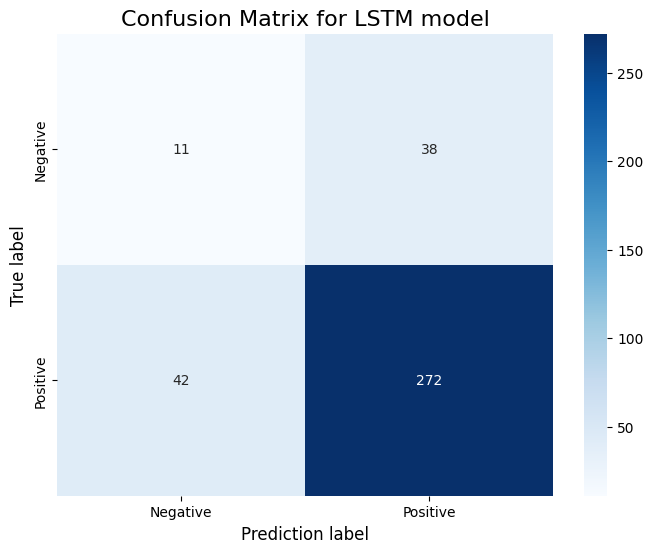


Classification report:

              precision    recall  f1-score   support

    Negative       0.21      0.22      0.22        49
    Positive       0.88      0.87      0.87       314

    accuracy                           0.78       363
   macro avg       0.54      0.55      0.54       363
weighted avg       0.79      0.78      0.78       363



In [26]:
model.eval()

all_true_labels = []
all_predicted_labels = []
with torch.no_grad():
    for inputs, labels in val_loader:

        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        probs = torch.sigmoid(outputs.squeeze())
        predicted = torch.round(probs)

        all_true_labels.extend(labels.cpu().numpy())
        all_predicted_labels.extend(predicted.cpu().numpy())

print(f"Checked {len(all_true_labels)} examples.")


cm = confusion_matrix(all_true_labels, all_predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix for LSTM model', fontsize=16)
plt.ylabel('True label', fontsize=12)
plt.xlabel('Prediction label', fontsize=12)
plt.show()


print("\nClassification report:\n")
report = classification_report(all_true_labels, all_predicted_labels, target_names=['Negative', 'Positive'])
print(report)

#The State-of-the-Art bertweet Model Approach

### Loading the Pre-trained Model:

In [41]:
!pip install -q transformers
from tqdm.auto import tqdm
import pandas as pd
from transformers import pipeline
from transformers import pipeline, AutoTokenizer
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="finiteautomata/bertweet-base-sentiment-analysis"
)
data = pd.read_csv("/content/drive/MyDrive/Data for GC/movie_reviews_table.csv")
data

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Device set to use cuda:0


,movie_id,movie_title,review_author,review_content,review_url,review_created_at,author_rating
0,1417059,Mountainhead,MovieGuys,"""Moutainhead""aspires to be more, than it reaso...",https://www.themoviedb.org/review/683fc1fdceb7...,2025-06-04T03:48:13.361Z,6.0
1,1001414,Fear Street: Prom Queen,Manuel São Bento,FULL SPOILER-FREE REVIEW @ https://movieswetex...,https://www.themoviedb.org/review/6830975507c6...,2025-05-23T15:42:13.781Z,5.0
2,1001414,Fear Street: Prom Queen,r96sk,<em>'Fear Street: Prom Queen'</em> is all too ...,https://www.themoviedb.org/review/683e459f8968...,2025-06-03T00:45:19.975Z,5.0
3,1098006,Fountain of Youth,Manuel São Bento,FULL SPOILER-FREE REVIEW @ https://fandomwire....,https://www.themoviedb.org/review/682f6478c2aa...,2025-05-22T17:52:56.672Z,7.0
4,1098006,Fountain of Youth,Brent Western,I came into this movie hearing that it wasn’t ...,https://www.themoviedb.org/review/6835fa592f02...,2025-05-27T17:46:01.181Z,8.0
...,...,...,...,...,...,...,...
2892,49538,X-Men: First Class,Travis Bell,I didn't love this movie. There were aspects a...,https://www.themoviedb.org/review/52aa15e919c2...,2013-12-12T20:00:41.186Z,7.5
2893,49538,X-Men: First Class,DoryDarko,"On IMDb, X-Men: First Class has garnered the h...",https://www.themoviedb.org/review/58ac565ac3a3...,2017-02-21T15:01:46.081Z,9.0
2894,49538,X-Men: First Class,r96sk,My favourite so far.\r\n\r\n<em>'X-Men: First ...,https://www.themoviedb.org/review/60a8736f66e4...,2021-05-22T02:58:55.623Z,8.0
2895,49538,X-Men: First Class,CinemaSerf,"If it's not sacrilegious for a Brit, I found t...",https://www.themoviedb.org/review/638ba3154202...,2022-12-03T19:27:17.507Z,7.0


In [42]:
data['review_content']

,review_content
0,"""Moutainhead""aspires to be more, than it reaso..."
1,FULL SPOILER-FREE REVIEW @ https://movieswetex...
2,<em>'Fear Street: Prom Queen'</em> is all too ...
3,FULL SPOILER-FREE REVIEW @ https://fandomwire....
4,I came into this movie hearing that it wasn’t ...
...,...
2892,I didn't love this movie. There were aspects a...
2893,"On IMDb, X-Men: First Class has garnered the h..."
2894,My favourite so far.\r\n\r\n<em>'X-Men: First ...
2895,"If it's not sacrilegious for a Brit, I found t..."


In [43]:
data['review_content_cleaned'] = data['review_content'].fillna('')

review_texts_list = data['review_content_cleaned'].astype(str).tolist()

In [44]:
sentiment_pipeline('review_texts_list')

[{'label': 'NEU', 'score': 0.9586560130119324}]

### Model and Training

In [45]:
MODEL_NAME = "finiteautomata/bertweet-base-sentiment-analysis"

try:
    sentiment_analyzer_bertweet = pipeline(
        "sentiment-analysis",
        model=MODEL_NAME,
        tokenizer=MODEL_NAME, # Explicitly specifying the tokenizer is good practice
        truncation=True       # This is the key parameter for handling long texts
    )
    print("Model and tokenizer loaded successfully.")
except Exception as e:
    print(f"An error occurred while loading the model or tokenizer: {e}")
    sentiment_analyzer_bertweet = None

# Proceed only if the pipeline was initialized successfully
if sentiment_analyzer_bertweet:

    # 2. Check if the required column exists in the DataFrame
    if 'review_content' in data.columns:
        # Extract the review texts into a list for processing
        review_texts = data['review_content'].tolist()
        sentiments_bertweet = sentiment_analyzer_bertweet(review_texts, batch_size=16)

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Device set to use cuda:0


Model and tokenizer loaded successfully.


In [46]:

data['bertweet_sentiment_label'] = [s['label'] for s in sentiments_bertweet]
data['bertweet_sentiment_score'] = [s['score'] for s in sentiments_bertweet]

data[['review_content','bertweet_sentiment_label','bertweet_sentiment_score']]

,review_content,bertweet_sentiment_label,bertweet_sentiment_score
0,"""Moutainhead""aspires to be more, than it reaso...",NEU,0.812231
1,FULL SPOILER-FREE REVIEW @ https://movieswetex...,NEG,0.702947
2,<em>'Fear Street: Prom Queen'</em> is all too ...,NEG,0.951138
3,FULL SPOILER-FREE REVIEW @ https://fandomwire....,POS,0.981472
4,I came into this movie hearing that it wasn’t ...,NEU,0.494397
...,...,...,...
2892,I didn't love this movie. There were aspects a...,NEG,0.938617
2893,"On IMDb, X-Men: First Class has garnered the h...",POS,0.957518
2894,My favourite so far.\r\n\r\n<em>'X-Men: First ...,POS,0.992338
2895,"If it's not sacrilegious for a Brit, I found t...",POS,0.622474


In [47]:
def analyze_single_text_bertweet(text_to_analyze):

            result = sentiment_analyzer_bertweet(text_to_analyze)[0]

            label = result['label']
            score = result['score']

            return label, score

    # Test Example
test_review = "Unbelievable shit! All characters think like they are in somewhere world and don't think too much"
label, score = analyze_single_text_bertweet(test_review)

print(f'Review: "{test_review}"')
print(f'Result: {label} (Accuracy: {score:.4f})\n')

    # Test Example
test_review_pos = "I absolutely loved this movie! The characters were amazing and the plot was fantastic. A must see!"
label, score = analyze_single_text_bertweet(test_review_pos)

print(f'Review: "{test_review_pos}"')
print(f'Result: {label} (Accuracy: {score:.4f})\n')

test_review_neg = "This was a complete waste of my time. The story was boring and the acting was just awful."
label, score = analyze_single_text_bertweet(test_review_neg)

print(f'Review: "{test_review_neg}"')
print(f'Result: {label} (Accuracy: {score:.4f})\n')

Review: "Unbelievable shit! All characters think like they are in somewhere world and don't think too much"
Result: NEU (Accuracy: 0.6537)

Review: "I absolutely loved this movie! The characters were amazing and the plot was fantastic. A must see!"
Result: POS (Accuracy: 0.9922)

Review: "This was a complete waste of my time. The story was boring and the acting was just awful."
Result: NEG (Accuracy: 0.9828)



In [34]:
test_review = "Unbelievable bad! All characters think like they are in somewhere world and don't think too much"
sentiment, prob = predict_sentiment(test_review, model, word_to_idx, device)
print(f'Review: "{test_review}"')
print(f'Result: {label} (Probability of Positive: {prob:.4f})\n')

Review: "Unbelievable bad! All characters think like they are in somewhere world and don't think too much"
Result: NEG (Probability of Positive: 0.1699)



### Viz

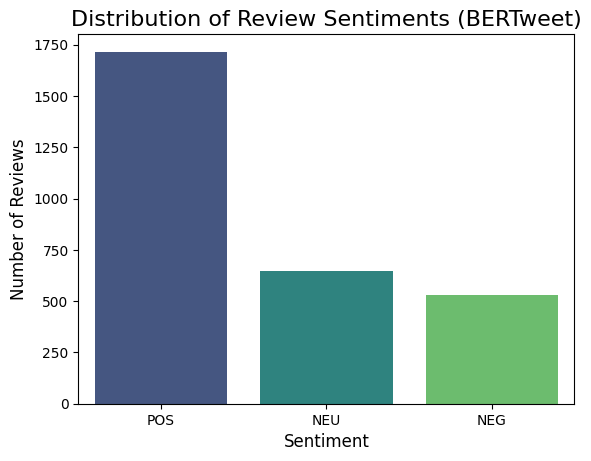

In [61]:
sns.barplot(
    x=sentiment_counts.index,
    y=sentiment_counts.values,
    hue=sentiment_counts.index,
    palette="viridis",
    legend=False
)

plt.title('Distribution of Review Sentiments (BERTweet)', fontsize=16)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.show()

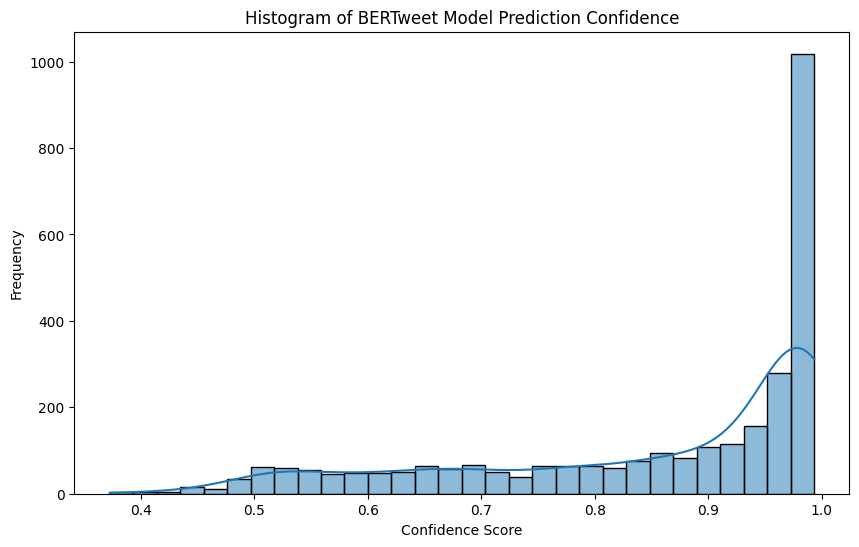


Average model confidence in its predictions: 0.8530


In [49]:
plt.figure(figsize=(10, 6))
sns.histplot(data['bertweet_sentiment_score'], bins=30, kde=True)
plt.title('Histogram of BERTweet Model Prediction Confidence')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.show()
avg_score = data['bertweet_sentiment_score'].mean()
print(f"\nAverage model confidence in its predictions: {avg_score:.4f}")

In [50]:
print(data.columns)

Index(['movie_id', 'movie_title', 'review_author', 'review_content',
       'review_url', 'review_created_at', 'author_rating',
       'review_content_cleaned', 'bertweet_sentiment_label',
       'bertweet_sentiment_score'],
      dtype='object')


Created 'true_label' column based on 'author_rating'. Here's a sample:
   author_rating true_label
0            6.0        NEU
1            5.0        NEU
2            5.0        NEU
3            7.0        NEU
4            8.0        POS
--------------------------------------------------


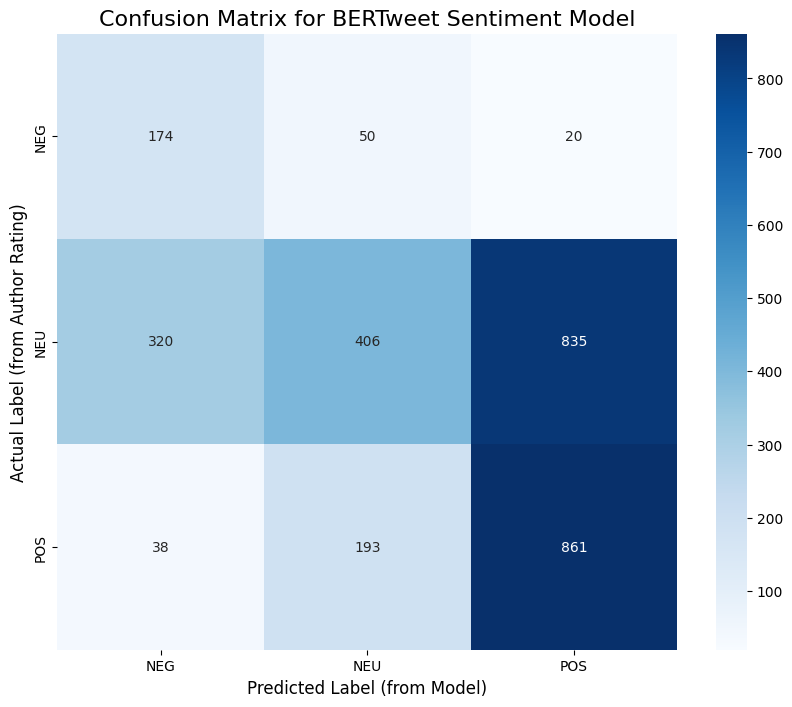


Classification Report:

              precision    recall  f1-score   support

         NEG       0.33      0.71      0.45       244
         NEU       0.63      0.26      0.37      1561
         POS       0.50      0.79      0.61      1092

    accuracy                           0.50      2897
   macro avg       0.48      0.59      0.48      2897
weighted avg       0.55      0.50      0.47      2897



In [51]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# --- STEP 1: Create the "True Label" column from 'author_rating' ---
# This is the most important step: converting numerical ratings to categorical labels.

def get_true_label(rating):
    if rating > 7:
        return 'POS'
    elif rating < 5:
        return 'NEG'
    else:
        return 'NEU'

# Apply this function to the 'author_rating' column to create our new 'true_label' column
data['true_label'] = data['author_rating'].apply(get_true_label)

print("Created 'true_label' column based on 'author_rating'. Here's a sample:")
print(data[['author_rating', 'true_label']].head())
print("-" * 50)


# --- STEP 2: Define your y_true and y_pred ---
# Now we can use our newly created column as the ground truth.
y_true = data['true_label']
y_pred = data['bertweet_sentiment_label']


# --- STEP 3: Generate and Plot the Confusion Matrix ---
class_names = ['NEG', 'NEU', 'POS']
cm = confusion_matrix(y_true, y_pred, labels=class_names)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix for BERTweet Sentiment Model', fontsize=16)
plt.ylabel('Actual Label (from Author Rating)', fontsize=12)
plt.xlabel('Predicted Label (from Model)', fontsize=12)
plt.show()


# --- STEP 4: Print the Classification Report ---
print("\nClassification Report:\n")
report = classification_report(y_true, y_pred, labels=class_names)
print(report)